In [1]:
import numba as nb

In [2]:
import squidpy as sq
import scanpy as sc
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix, isspmatrix_csr

In [3]:
import liana as li

In [4]:
from matplotlib.pyplot import hist

In [5]:
from liana.method._global_lr_pipe import _global_lr_pipe
from liana.method.sp._spatialdm import _get_ordered_matrix, _standardize_matrix

In [ ]:
# # scHOT data
# counts = pd.read_csv("data/counts_mat.csv")
# weights = pd.read_csv("data/weight_mat.csv")
# var = pd.DataFrame(counts[['Unnamed: 0']]).set_index('Unnamed: 0')
# var.index.name = None
# adata = sc.AnnData(X=csr_matrix(counts.drop(counts.columns[0], axis=1), dtype=np.float32).T, var=var)
# adata.obsm['proximity'] = csr_matrix(weights)

In [6]:
# scHOT data test
adata = sc.read_h5ad("test_spatial.h5ad")
resource = pd.DataFrame({"ligand":["Dnm1l", "Arrb1", "Igf2", "Dnm1l"], "receptor":["Gucy1b3", "Mtor", "Tuba1a", "Fam63b"]})
dist = adata.obsm['proximity']

In [7]:
n_perm = 100
seed = 0

In [9]:
# full visium slide
# load the pre-processed dataset
img = sq.datasets.visium_hne_image()
adata = sq.datasets.visium_hne_adata()

li.mt.get_spatial_proximity(adata=adata, parameter=200, bypass_diagonal=False, cutoff=0.1, family="exponential")
dist = adata.obsm['proximity']

my_p = li.pl.proximity_plot(adata, idx=100)
resource = li.resource.select_resource("mouseconsensus")

In [10]:
temp, lr_res, ligand_pos, receptor_pos = _global_lr_pipe(adata=adata,
                                                         resource=resource,
                                                         expr_prop=0.05,
                                                         use_raw=False,
                                                         verbose=True,
                                                         layer=None,
                                                         _key_cols=['ligand_complex', 'receptor_complex'],
                                                         _complex_cols=['ligand_means', 'receptor_means'],
                                                         _obms_keys=['proximity'],
                                                         resource_name=None
                                                         )

Using `.X`!


In [11]:
# lr_res = lr_res.head(50)

In [12]:
x_mat = _get_ordered_matrix(temp.X, ligand_pos, lr_res.ligand).A.astype(np.float64).T
y_mat = _get_ordered_matrix(temp.X, receptor_pos, lr_res.receptor).A.astype(np.float64).T

In [13]:
lr_res.head()

,interaction,ligand,receptor,ligand_complex,receptor_complex,ligand_means,ligand_props,receptor_means,receptor_props,prop_min
0,Dll1&Notch1,Dll1,Notch1,Dll1,Notch1,0.037283,0.057292,0.216689,0.276786,0.057292
1,Adam10&Notch1,Adam10,Notch1,Adam10,Notch1,0.623617,0.651786,0.216689,0.276786,0.276786
2,Jag1&Notch1,Jag1,Notch1,Jag1,Notch1,0.051299,0.075893,0.216689,0.276786,0.075893
3,Adam17&Notch1,Adam17,Notch1,Adam17,Notch1,0.121026,0.167783,0.216689,0.276786,0.167783
4,Dlk1&Notch1,Dlk1,Notch1,Dlk1,Notch1,0.236641,0.213542,0.216689,0.276786,0.213542


In [14]:
@nb.njit(nb.float64(nb.float64[:], nb.float64[:], nb.float64[:], nb.float64, nb.boolean), cache=True)
def _wcorr(x, y, w, wsum, rank):
    
    if rank:
        x = np.argsort(x).argsort().astype(nb.float64)
        y = np.argsort(y).argsort().astype(nb.float64)
    
    wx = w * x
    wy = w * y
    
    numerator = wsum * sum(wx * y) - sum(wx) * sum(wy)
    
    denominator_x = wsum * sum(w * (x**2)) - sum(wx)**2
    denominator_y = wsum * sum(w * (y**2)) - sum(wy)**2
    denominator = (denominator_x * denominator_y)
    
    if (denominator == 0) or (numerator == 0):
        return 0
    
    return numerator / (denominator**0.5)

In [15]:
@nb.njit(nb.float64(nb.float64[:], nb.float64[:], nb.float64[:], nb.float64, nb.int64), cache=True)
def _wcoex(x, y, w, wsum, method):
        if method == 0: # pearson
            c = _wcorr(x, y, w, wsum, False)
        elif method == 1: # spearman
            c = _wcorr(x, y, w, wsum, True)
        else: 
            raise ValueError("method not supported")
        return c

In [16]:
# 0 = pearson, 1 = spearman
@nb.njit(nb.float64[:,:](nb.float64[:,:], nb.float64[:,:], nb.float64[:,:], nb.float64, nb.int64), parallel=True, cache=True)
def masked_coexpression(x_mat, y_mat, weight, weight_thr, method):
    spot_n = x_mat.shape[0]
    xy_n = x_mat.shape[1]
    
    local_correlations = np.zeros((spot_n, xy_n), dtype=nb.float64)
    
    for i in nb.prange(spot_n):
        w = weight[i, :]
        msk = w > weight_thr
        wsum = sum(w[msk])
        
        for j in range(xy_n):
            x = x_mat[:, j][msk]
            y = y_mat[:, j][msk]
            
            local_correlations[i, j] = _wcoex(x, y, w[msk], wsum, method)
    
    return local_correlations

In [17]:
dist = adata.obsm['proximity']
weight = dist.A.astype(np.float64)

In [18]:
%%time
masked_pc = masked_coexpression(x_mat, y_mat, weight, weight_thr=0.0, method=0)

CPU times: user 57.1 s, sys: 247 ms, total: 57.4 s
Wall time: 5.73 s


In [19]:
%%time
masked_sp = masked_coexpression(x_mat, y_mat, weight, weight_thr=0.0, method=1)

CPU times: user 2min 38s, sys: 199 ms, total: 2min 38s
Wall time: 15 s


In [20]:
from scipy.spatial.distance import jaccard, cosine

Fully-vectorized

In [21]:
import squidpy as sq
import scanpy as sc
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix, isspmatrix_csr

In [22]:
import liana as li

In [23]:
from matplotlib.pyplot import hist
from scipy.stats import spearmanr, pearsonr

In [24]:
from liana.method._global_lr_pipe import _global_lr_pipe
from liana.method.sp._spatialdm import _get_ordered_matrix, _standardize_matrix

In [25]:
from scipy.stats import rankdata

In [26]:
# ligand-receptor mats
ligand_mat = _get_ordered_matrix(temp.X, ligand_pos, lr_res.ligand).T
receptor_mat = _get_ordered_matrix(temp.X, receptor_pos, lr_res.receptor).T

In [27]:
def _vectorized_correlations(x_mat, y_mat, dist, method="pearson"):
    if method not in ["pearson", "spearman"]:
        raise ValueError("method must be one of 'pearson', 'spearman'")
    
    # transpose
    x_mat, y_mat = x_mat.T, y_mat.T
    
    weight = dist.A.T
    weight_sums = np.sum(weight, axis = 0).flatten()
        
    if method=="spearman":
        x_mat = rankdata(x_mat, axis=1)
        y_mat = rankdata(y_mat, axis=1)
    
    # standard pearson
    n1 = (((x_mat * y_mat).dot(weight)) * weight_sums)
    n2 = (x_mat.dot(weight)) * (y_mat.dot(weight))
    numerator = n1 - n2
    
    denominator_x = (weight_sums * (x_mat ** 2).dot(weight)) - (x_mat.dot(weight))**2
    denominator_y = (weight_sums * (y_mat ** 2).dot(weight)) - (y_mat.dot(weight))**2
    denominator = np.sqrt(denominator_x * denominator_y)
    denominator[denominator == 0] = np.finfo(np.float32).eps # add noise to avoid division by zero
    
    local_corrs = (numerator / denominator)
    
    return local_corrs

In [28]:
dist = adata.obsm['proximity']

In [29]:
local_pc = _vectorized_correlations(x_mat = ligand_mat.A, y_mat=receptor_mat.A, dist=dist, method="pearson")

In [30]:
local_sp = _vectorized_correlations(x_mat = ligand_mat.A, y_mat=receptor_mat.A, dist=dist, method="spearman")

In [31]:
def _vectorized_wcosine(x_mat, y_mat, dist):
    
    # transpose
    x_mat, y_mat = x_mat.T, y_mat.T    
    weight = dist.A.T
    
    xy_dot = (x_mat * y_mat).dot(weight)
    x_dot = (x_mat ** 2).dot(weight.T)
    y_dot = (y_mat ** 2).dot(weight.T)
    denominator = (x_dot * y_dot) + np.finfo(np.float32).eps
    
    return xy_dot / (denominator**0.5)

In [32]:
local_cos = _vectorized_wcosine(x_mat = ligand_mat.A, y_mat=receptor_mat.A, dist=dist)

In [33]:
local_cos

array([[0.24852307, 0.        , 0.23423988, ..., 0.3214664 , 0.16711654,
        0.        ],
       [0.2842012 , 0.36573985, 0.44620898, ..., 0.5688991 , 0.42216256,
        0.42207965],
       [0.        , 0.        , 0.        , ..., 0.        , 0.20977075,
        0.5764741 ],
       ...,
       [0.        , 0.        , 0.08510602, ..., 0.37775886, 0.29190704,
        0.36504358],
       [0.18384704, 0.        , 0.5605194 , ..., 0.1044414 , 0.6970964 ,
        0.20911969],
       [0.        , 0.27643934, 0.21995164, ..., 0.29707506, 0.        ,
        0.        ]], dtype=float32)

In [34]:
local_cos.shape

(1409, 2688)

In [35]:
def _vectorized_jaccard(x_mat, y_mat, dist):
    # binarize
    x_mat, y_mat = x_mat > 0, y_mat > 0
    # transpose
    x_mat, y_mat = x_mat.T, y_mat.T    
    weight = dist.A.T
    
    # intersect and union
    numerator = np.dot(np.minimum(x_mat, y_mat), weight)
    denominator = np.dot(np.maximum(x_mat, y_mat), weight) + np.finfo(np.float32).eps
    
    return numerator / denominator

In [36]:
local_jc = _vectorized_jaccard(x_mat = ligand_mat.A, y_mat=receptor_mat.A, dist=dist)

In [37]:
local_jc

array([[0.15256435, 0.        , 0.13490444, ..., 0.08492552, 0.0626891 ,
        0.        ],
       [0.28213286, 0.15703203, 0.4787594 , ..., 0.4010069 , 0.29801047,
        0.25343168],
       [0.        , 0.        , 0.        , ..., 0.        , 0.07128162,
        0.3342702 ],
       ...,
       [0.        , 0.        , 0.07132728, ..., 0.22662593, 0.1191683 ,
        0.17687309],
       [0.04772777, 0.        , 0.45703325, ..., 0.05781471, 0.4462099 ,
        0.14840274],
       [0.        , 0.1109866 , 0.11009347, ..., 0.23526588, 0.        ,
        0.        ]], dtype=float32)

In [38]:
from liana.method.sp._spatial_utils import _local_permutation_pvals

In [39]:
%%time
local_pc_pvals = _local_permutation_pvals(x_mat = ligand_mat.A, 
                                          y_mat = receptor_mat.A, 
                                          local_truth=local_pc,
                                          local_fun=_vectorized_correlations,
                                          dist=dist, 
                                          n_perm=n_perm, 
                                          positive_only=False,
                                          seed=seed)

100%|██████████| 100/100 [01:24<00:00,  1.18it/s]

CPU times: user 11min 27s, sys: 3min 53s, total: 15min 20s
Wall time: 1min 24s


In [40]:
local_pc_pvals

array([[0.68, 1.  , 0.77, ..., 0.11, 0.68, 1.  ],
       [0.23, 0.82, 0.78, ..., 0.08, 0.28, 0.94],
       [0.48, 0.69, 0.11, ..., 0.11, 0.44, 0.  ],
       ...,
       [0.66, 0.12, 0.09, ..., 0.28, 0.95, 0.44],
       [0.65, 0.57, 0.4 , ..., 0.3 , 0.  , 0.99],
       [1.  , 0.35, 0.64, ..., 0.08, 1.  , 1.  ]])

In [41]:
local_sp = _vectorized_correlations(x_mat = ligand_mat.A, y_mat=receptor_mat.A, dist=dist, method="spearman")

In [42]:
local_sp_pvals = _local_permutation_pvals(x_mat = ligand_mat.A, 
                                          y_mat = receptor_mat.A, 
                                          local_truth=local_sp,
                                          local_fun=_vectorized_correlations,
                                          dist=dist, 
                                          n_perm=n_perm, 
                                          positive_only=False,
                                          seed=seed,
                                          method="spearman"
                                          )

100%|██████████| 100/100 [04:04<00:00,  2.45s/it]


In [44]:
local_sp_pvals.shape

(1409, 2688)

In [45]:
spearmanr(local_sp_pvals[1,:], local_pc_pvals[1,:])

SignificanceResult(statistic=0.9075715508221657, pvalue=0.0)

Global summary of the local scores:

In [46]:
lr_res.loc[:,['pearson_mean','pearson_sd']] = np.vstack([np.mean(local_pc, axis=1), np.std(local_pc, axis=1)]).T

In [47]:
lr_res.sort_values(by='pearson_mean', ascending=False)

,interaction,ligand,receptor,ligand_complex,receptor_complex,ligand_means,ligand_props,receptor_means,receptor_props,prop_min,pearson_mean,pearson_sd
752,App&Aplp1,App,Aplp1,App,Aplp1,3.040105,0.998140,3.126448,0.999628,0.998140,0.315534,0.235278
1720,Nptx1&Nptxr,Nptx1,Nptxr,Nptx1,Nptxr,1.045611,0.723586,1.783589,0.889509,0.723586,0.181391,0.249799
1687,Rtn4&Lingo1,Rtn4,Lingo1,Rtn4,Lingo1,2.446542,0.992188,1.553612,0.893601,0.893601,0.170007,0.248868
1222,Sema4d&Plxnb3,Sema4d,Plxnb3,Sema4d,Plxnb3,0.544131,0.524554,0.190867,0.219866,0.219866,0.169865,0.246063
550,App&Aplp2,App,Aplp2,App,Aplp2,3.040105,0.998140,2.031858,0.985119,0.985119,0.163134,0.221257
...,...,...,...,...,...,...,...,...,...,...,...,...
1034,L1cam&Ptprz1,L1cam,Ptprz1,L1cam,Ptprz1,0.788955,0.692708,1.292046,0.919643,0.692708,-0.101387,0.209442
1102,L1cam&Cd9,L1cam,Cd9,L1cam,Cd9,0.788955,0.692708,0.870121,0.682292,0.682292,-0.104623,0.240631
1551,Apoe&Chrna4,Apoe,Chrna4,Apoe,Chrna4,4.075930,1.000000,0.445172,0.465774,0.465774,-0.117212,0.219662
1679,Psap&Gpr37l1,Psap,Gpr37l1,Psap,Gpr37l1,3.318095,0.999628,1.765455,0.977307,0.977307,-0.121676,0.225601


Plot to check the distribution of the local scores:

In [48]:
from liana.method.sp._spatialdm import spatialdm

In [49]:
spatialdm(adata=adata, resource_name="MouseConsensus", pvalue_method='analytical', verbose=True, use_raw=False)

Using `.X`!


In [50]:
local_pvals = li.ut.obsm_to_adata(adata, obsm_key='local_pvals')

In [51]:
local_r = li.ut.obsm_to_adata(adata, obsm_key='local_r')

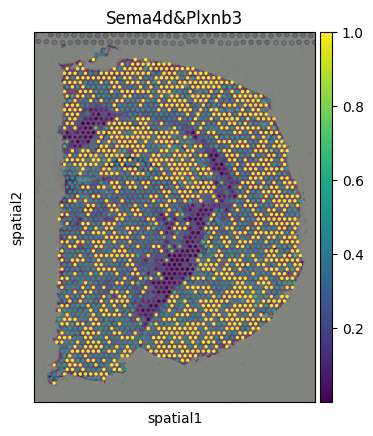

In [52]:
sc.pl.spatial(local_pvals, color=['Sema4d&Plxnb3'])

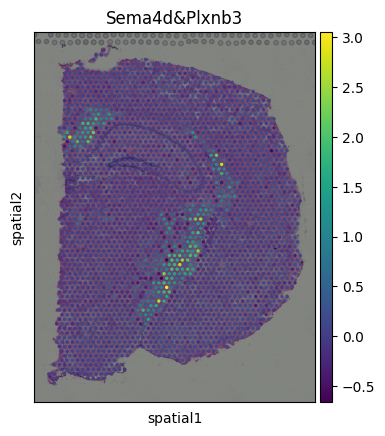

In [53]:
sc.pl.spatial(local_r, color=['Sema4d&Plxnb3'])

In [54]:
adata.obsm['local_r']

interaction,Dll1&Notch1,Adam10&Notch1,Jag1&Notch1,Adam17&Notch1,Dlk1&Notch1,Cntn1&Notch1,Dlk2&Notch1,Dll3&Notch1,Jag2&Notch1,Mfap2&Notch1,...,S100a1&Ryr1,Gsto1&Ryr1,Arf6&Pld1,Arf6&Smap1,P4hb&Mttp,Gad1&Grm4,Rims1&Slc17a7,Nucb2&Erap1,Fstl5&Sdk2,Pi16&Mfap3l
AAACAAGTATCTCCCA-1,-0.003302,0.022610,-0.004543,-0.010718,-0.020956,0.060061,-0.024712,-0.009613,-0.024236,-0.007523,...,-0.004998,0.033540,0.040607,0.159008,-0.028573,0.055666,0.614320,0.033978,0.052445,-0.009248
AAACAATCTACTAGCA-1,0.004959,0.082944,0.006823,0.016097,0.031474,-0.096749,0.037116,0.014438,0.036400,0.011299,...,0.053331,-0.082624,-0.109467,-0.134589,0.057436,-0.600430,1.600961,-0.006971,0.025097,0.002092
AAACACCAATAACTGC-1,-0.009799,-0.004685,-0.013483,-0.031810,0.195477,-0.095386,-0.073346,-0.028531,-0.071933,-0.022328,...,-0.004040,0.031481,0.023500,0.134920,0.021919,0.027075,1.967994,-0.052245,0.151331,0.006666
AAACAGAGCGACTCCT-1,0.033936,0.013218,-0.001813,-0.004276,-0.008362,-0.064615,0.025393,-0.003836,-0.009670,-0.003002,...,0.000622,-0.009529,-0.012811,0.166983,0.118437,-0.261652,-0.831188,-0.009534,0.044024,-0.009691
AAACCGGGTAGGTACC-1,-0.004271,0.042767,0.064903,-0.013863,0.043673,-0.018976,0.082236,-0.012434,-0.031349,-0.009731,...,0.015521,0.029924,0.010465,-0.250671,-0.009702,-1.782283,0.765695,0.030703,0.120984,0.008656
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTTGTGTGTCAAGA-1,0.466393,-0.034288,-0.043805,0.394882,-0.202072,-0.342426,-0.238290,-0.092694,-0.233699,-0.072540,...,-0.074931,-0.000783,-0.026011,-0.264315,0.040279,-0.059715,-0.003475,-0.002617,0.012486,-0.000649
TTGTTTCACATCCAGG-1,-0.050142,0.070849,-0.048550,-0.040628,-0.162522,0.048305,-0.022675,0.012333,0.031093,0.009651,...,0.042843,0.005243,0.007131,0.018991,0.014606,0.033449,-0.708784,-0.038276,0.023006,0.013076
TTGTTTCATTAGTCTA-1,0.004250,0.071080,0.005847,0.013795,-0.058400,0.014965,0.031807,-0.073000,-0.054178,0.009683,...,0.003620,0.003577,-0.021586,-0.078985,0.004028,-0.386612,2.485541,0.013969,-0.260895,0.019689
TTGTTTCCATACAACT-1,-0.004953,0.008888,-0.006815,0.075661,-0.031439,0.032704,-0.037075,-0.014422,-0.036360,-0.011286,...,0.013072,0.040281,0.005077,-0.104236,0.008618,-1.071637,-0.538094,-0.020392,-0.014132,0.004795


In [55]:
def embed_score_to_adata(adata, score, score_name):
    score =  pd.DataFrame(score,
                          columns=adata.obsm['local_r'].columns,
                          index=adata.obsm['local_r'].index)
    adata.obsm[score_name] = score

In [56]:
# Masked Pearson correlation
embed_score_to_adata(adata, masked_pc, 'masked_pc')

# Vectorized Pearson correlation
embed_score_to_adata(adata, local_pc.T, 'local_pc')

In [57]:
# Masked Spearman correlation
embed_score_to_adata(adata, masked_sp, 'masked_sp')
# Vectorized Spearman correlation
embed_score_to_adata(adata, local_sp.T, 'local_sp')

In [58]:
# Vectorized Jaccard index
embed_score_to_adata(adata, local_jc.T, 'local_jc')

In [59]:
# Vectorized Cosine similarity
embed_score_to_adata(adata, local_cos.T, 'local_cos')

Plot to check the distribution of the local scores:

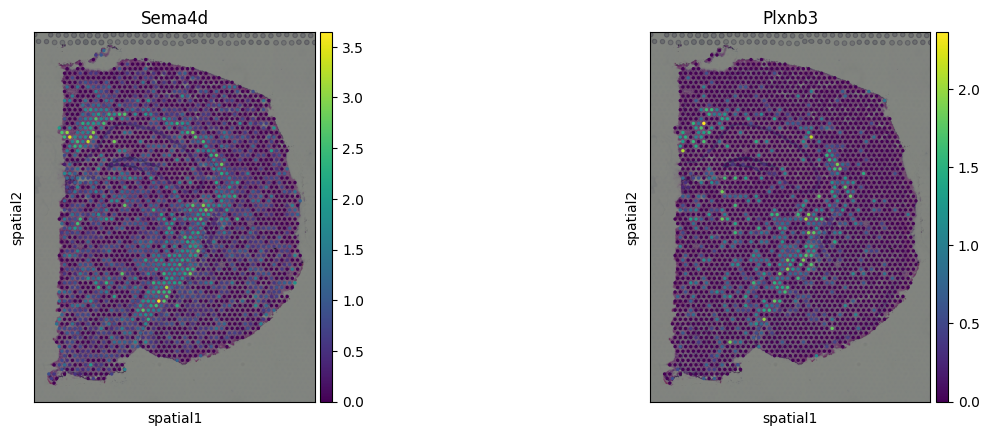

In [60]:
sc.pl.spatial(adata, color=['Sema4d', 'Plxnb3'], use_raw=False)

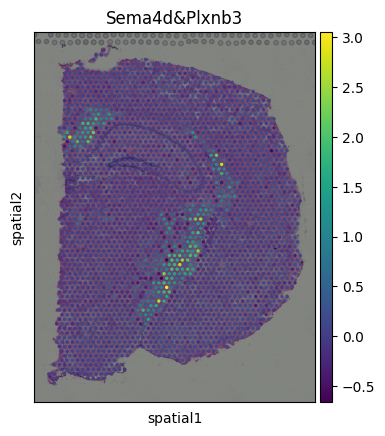

In [61]:
local_r = li.ut.obsm_to_adata(adata, obsm_key='local_r')
sc.pl.spatial(local_r, color=['Sema4d&Plxnb3'])

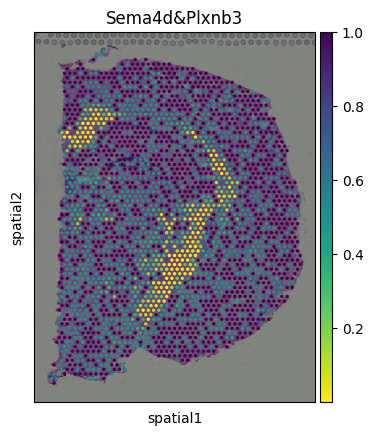

In [73]:
sc.pl.spatial(local_pvals, color=['Sema4d&Plxnb3'], cmap='viridis_r')

Pearson

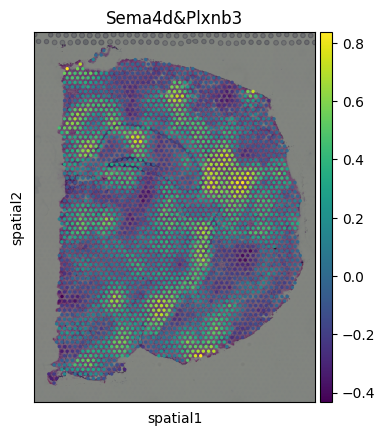

In [63]:
masked_pc = li.ut.obsm_to_adata(adata, obsm_key='masked_pc')
sc.pl.spatial(masked_pc, color=['Sema4d&Plxnb3'])

In [64]:
np.average(masked_pc.X)

0.016911443

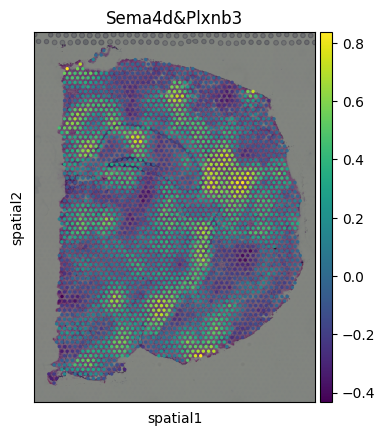

In [65]:
local_pc = li.ut.obsm_to_adata(adata, obsm_key='local_pc')
sc.pl.spatial(local_pc, color=['Sema4d&Plxnb3'])

In [66]:
np.average(local_pc.X)

0.016911438

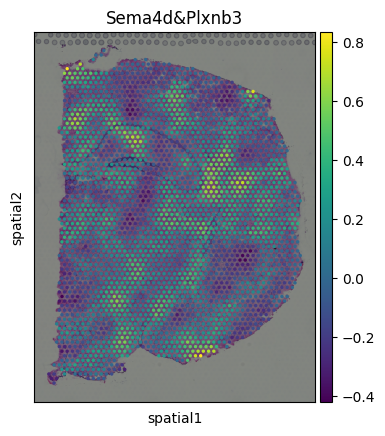

In [67]:
local_sp = li.ut.obsm_to_adata(adata, obsm_key='local_sp')
sc.pl.spatial(local_sp, color=['Sema4d&Plxnb3'])

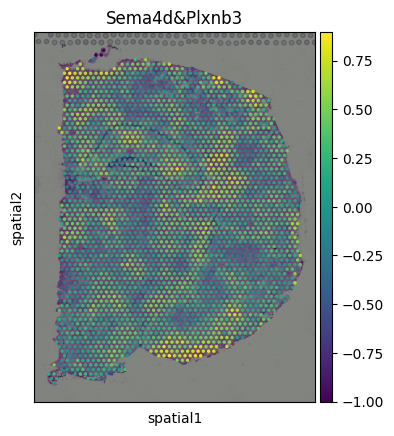

In [68]:
masked_sp = li.ut.obsm_to_adata(adata, obsm_key='masked_sp')
sc.pl.spatial(masked_sp, color=['Sema4d&Plxnb3'])

Jaccard

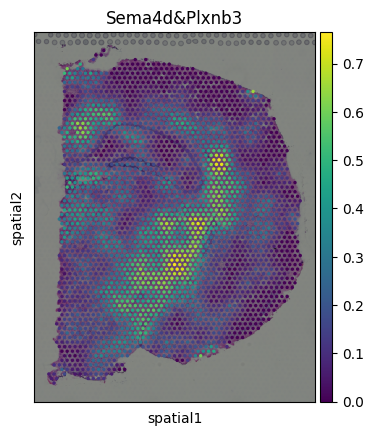

In [69]:
local_jc = li.ut.obsm_to_adata(adata, obsm_key='local_jc')
sc.pl.spatial(local_jc, color=['Sema4d&Plxnb3'])

Cosine

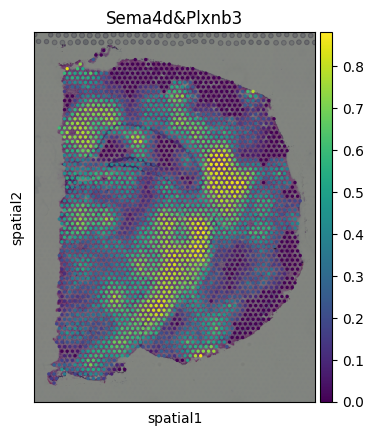

In [70]:
local_cos = li.ut.obsm_to_adata(adata, obsm_key='local_cos')
sc.pl.spatial(local_cos, color=['Sema4d&Plxnb3'])

Pvals

In [71]:
embed_score_to_adata(adata, local_pc_pvals.T, 'local_pc_pvals')
local_pc_pvals = li.ut.obsm_to_adata(adata, obsm_key='local_pc_pvals')

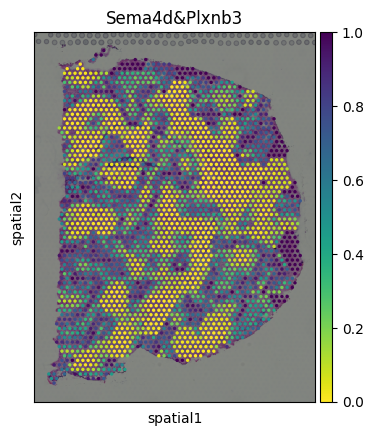

In [72]:
sc.pl.spatial(local_pc_pvals, color=['Sema4d&Plxnb3'], cmap='viridis_r')

In [74]:
# LASSO regression on each spot?